<a href="https://colab.research.google.com/github/b2200765008/Detecting-Endangered-Species-from-Camera-Trap/blob/main/nodels-CNN-SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import cv2

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import layers, models, losses
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip /content/drive/MyDrive/species_resized.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: Tapirus_bairdii_resized/image 2669.jpg  
  inflating: Tapirus_bairdii_resized/image 267.jpg  
  inflating: Tapirus_bairdii_resized/image 2670.jpg  
  inflating: Tapirus_bairdii_resized/image 2671.jpg  
  inflating: Tapirus_bairdii_resized/image 2672.jpg  
  inflating: Tapirus_bairdii_resized/image 2673.jpg  
  inflating: Tapirus_bairdii_resized/image 2674.jpg  
  inflating: Tapirus_bairdii_resized/image 2675.jpg  
  inflating: Tapirus_bairdii_resized/image 2676.jpg  
  inflating: Tapirus_bairdii_resized/image 2677.jpg  
  inflating: Tapirus_bairdii_resized/image 2678.jpg  
  inflating: Tapirus_bairdii_resized/image 2679.jpg  
  inflating: Tapirus_bairdii_resized/image 268.jpg  
  inflating: Tapirus_bairdii_resized/image 2680.jpg  
  inflating: Tapirus_bairdii_resized/image 2681.jpg  
  inflating: Tapirus_bairdii_resized/image 2682.jpg  
  inflating: Tapirus_bairdii_resized/image 2683.jpg  
  inflating: Tapirus_bairdii_resized/

In [ ]:
def measure_brightness(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray_image)
    return brightness

def custom_preprocessing(image):
    # Measure brightness
    brightness_level = measure_brightness(image)

    # Adjust brightness only for night images (customize this condition)
    if brightness_level < 0.5:

        # Apply brightness adjustment (customize the factor)
        brightness_factor = 2.0
        image = cv2.convertScaleAbs(image, alpha=brightness_factor, beta=0)

    return image

In [ ]:
pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio('images', output="output", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 35641 files [00:12, 2906.37 files/s]


In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    # rotation_range = 15,
    # brightness_range = (0.7,1.3),
    cval=0,
    preprocessing_function=custom_preprocessing,
    dtype = 'float32'
    )

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    dtype='float32'
    )

test_datagen = ImageDataGenerator(
    rescale = 1./255,
    dtype='float32'
    )

train_set = train_datagen.flow_from_directory(
                '/content/output/train',
                target_size = (64,64),
                batch_size =64,
                class_mode = 'categorical',
                shuffle = True,
                seed=42,)



val_set = val_datagen.flow_from_directory(
                '/content/output/val',
                target_size = (64,64),
                batch_size =64,
                class_mode = 'categorical',
                shuffle=False,
                seed=42,
                )

test_set = test_datagen.flow_from_directory(
                '/content/output/test',
                target_size = (64,64),
                batch_size =64,
                class_mode = 'categorical',
                shuffle=False,
                seed=42,
                )

Found 28509 images belonging to 10 classes.
Found 3560 images belonging to 10 classes.
Found 3572 images belonging to 10 classes.


In [ ]:
class_indices = val_set.class_indices
class_labels = list(class_indices.keys())
num_classes = len(class_labels)
class_counts = [sum(val_set.classes == class_indices[label]) for label in class_labels]

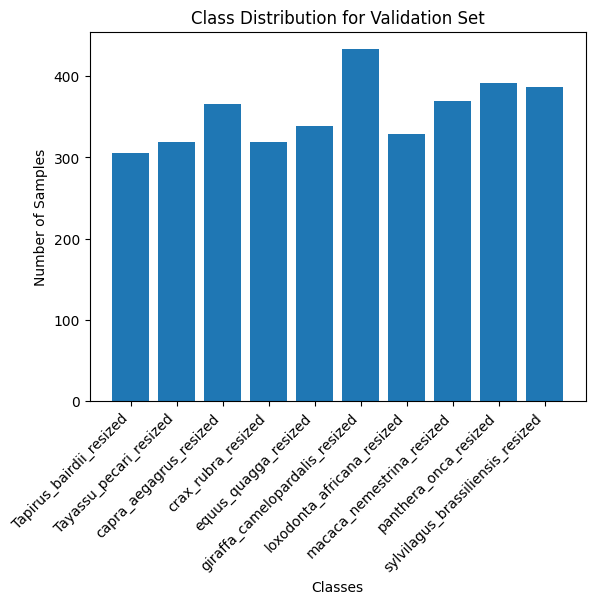

In [ ]:
plt.bar(class_labels, class_counts)
plt.xlabel('Classes')
plt.xticks(rotation=45, ha="right")
plt.ylabel('Number of Samples')
plt.title('Class Distribution for Validation Set')
plt.show()

In [ ]:
def create_model():
    model = Sequential([

        Conv2D(filters=32, kernel_size=(5, 5), padding='valid', input_shape=(128,128, 3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),


        Conv2D(filters=16, kernel_size=(5, 5), padding='valid', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),


        Flatten(),
        Dense(units=128, activation='relu'),
        Dropout(0.5),
        Dense(units=10, activation='softmax')
    ])

    return model

In [ ]:
model = create_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 batch_normalization (Batch  (None, 124, 124, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 124, 124, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 16)        12816     
                                                                 
 batch_normalization_1 (Bat  (None, 58, 58, 16)        6

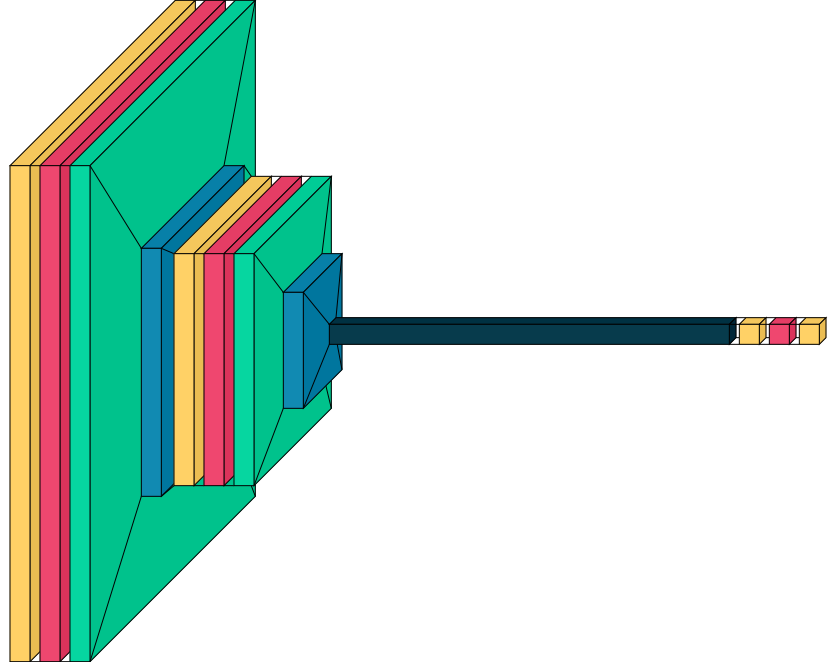

In [ ]:
import visualkeras
visualkeras.layered_view(model)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=3)
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
history = model.fit(train_set, epochs=20, validation_data=val_set,
                       verbose=2,
                       batch_size = 128,
                       callbacks=[reduce_lr,early_stopping])

Epoch 1/20
446/446 - 62s - loss: 1.6150 - accuracy: 0.4527 - val_loss: 1.3540 - val_accuracy: 0.5537 - lr: 1.0000e-05 - 62s/epoch - 139ms/step
Epoch 2/20
446/446 - 43s - loss: 1.0403 - accuracy: 0.6485 - val_loss: 0.7423 - val_accuracy: 0.7674 - lr: 1.0000e-05 - 43s/epoch - 96ms/step
Epoch 3/20
446/446 - 45s - loss: 0.8415 - accuracy: 0.7176 - val_loss: 0.6029 - val_accuracy: 0.8140 - lr: 1.0000e-05 - 45s/epoch - 102ms/step
Epoch 4/20
446/446 - 43s - loss: 0.7209 - accuracy: 0.7565 - val_loss: 0.5249 - val_accuracy: 0.8362 - lr: 1.0000e-05 - 43s/epoch - 97ms/step
Epoch 5/20
446/446 - 41s - loss: 0.6316 - accuracy: 0.7880 - val_loss: 0.4585 - val_accuracy: 0.8587 - lr: 1.0000e-05 - 41s/epoch - 93ms/step
Epoch 6/20
446/446 - 42s - loss: 0.5688 - accuracy: 0.8142 - val_loss: 0.4063 - val_accuracy: 0.8705 - lr: 1.0000e-05 - 42s/epoch - 94ms/step
Epoch 7/20
446/446 - 43s - loss: 0.5109 - accuracy: 0.8302 - val_loss: 0.3631 - val_accuracy: 0.8888 - lr: 1.0000e-05 - 43s/epoch - 97ms/step
Epoc

In [ ]:
labels = {
    0: "Tapirus_bairdii",
    1: "Tayassu_pecari",
    2: "Capra_aegagrus",
    3: "Crax_rubra",
    4: "Equus_quagga",
    5: "giraffa_camelopardalis",
    6: "Loxodonta_africana",
    7: "Macaca_nemestrina",
    8: "Panthera_onca",
    9: "Sylvilagus_brassiliensis"
}

In [ ]:
predictions = model.predict(test_set)
y_pred = np.argmax(predictions, axis=1)
y_true = test_set.classes
print(y_true)
print(classification_report(y_true, y_pred, target_names=labels.values()))

56/56 [==============================] - 6s 106ms/step
[0 0 0 ... 9 9 9]
                          precision    recall  f1-score   support

         Tapirus_bairdii       0.93      0.95      0.94       307
          Tayassu_pecari       1.00      1.00      1.00       320
          Capra_aegagrus       0.95      0.98      0.96       367
              Crax_rubra       0.99      1.00      0.99       320
            Equus_quagga       0.95      0.92      0.93       340
  giraffa_camelopardalis       0.91      0.92      0.92       435
      Loxodonta_africana       0.92      0.89      0.90       330
       Macaca_nemestrina       0.97      0.99      0.98       372
           Panthera_onca       0.97      0.90      0.94       393
Sylvilagus_brassiliensis       0.96      0.99      0.98       388

                accuracy                           0.95      3572
               macro avg       0.95      0.95      0.95      3572
            weighted avg       0.95      0.95      0.95      3572



In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
  layer.trainable = False

# Create a new model with custom dense layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))  # Replace num_classes with your actual number of classes

model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming you have a train_generator and val_generator from your ImageDataGenerator
history = model.fit(train_set, epochs=20, validation_data=val_set, verbose=2,callbacks=[reduce_lr,early_stopping])


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 21140042 (80.64 MB)
Trainable params: 6425354 (24.51 MB)
Non-trainable params: 14714688 (56.13 MB)
________

In [ ]:
predictions = model.predict(val_set)
y_pred = np.argmax(predictions, axis=1)
y_true = val_set.classes
print(y_true)
print(classification_report(y_true, y_pred, target_names=labels.values()))

223/223 [==============================] - 26s 118ms/step
[0 0 0 ... 9 9 9]
                          precision    recall  f1-score   support

         Tapirus_bairdii       0.87      0.80      0.83       612
          Tayassu_pecari       0.99      1.00      1.00       639
          Capra_aegagrus       0.91      0.94      0.93       732
              Crax_rubra       0.88      0.97      0.92       638
            Equus_quagga       0.73      0.84      0.78       678
  giraffa_camelopardalis       0.69      0.64      0.67       867
      Loxodonta_africana       0.78      0.70      0.74       658
       Macaca_nemestrina       0.96      0.90      0.93       741
           Panthera_onca       0.83      0.76      0.79       784
Sylvilagus_brassiliensis       0.81      0.90      0.85       774

                accuracy                           0.84      7123
               macro avg       0.84      0.84      0.84      7123
            weighted avg       0.84      0.84      0.84      712

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Create a new model with custom dense layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(10, activation='softmax'))  # Replace 10 with your actual number of classes

# Compile the model
optimizer = Adam(learning_rate=0.0005)  # Adjust the learning rate as needed
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_set,
    epochs=20,
    validation_data=val_set,
    verbose=2,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),  # Add early stopping
        ModelCheckpoint('best_model.h5', save_best_only=True),  # Save the best model
        reduce_lr,
        early_stopping
    ]
)


Epoch 1/20
446/446 - 163s - loss: 0.3254 - accuracy: 0.9162 - val_loss: 3.7147 - val_accuracy: 0.1110 - lr: 5.0000e-04 - 163s/epoch - 366ms/step
Epoch 2/20
446/446 - 109s - loss: 0.1025 - accuracy: 0.9696 - val_loss: 3.9656 - val_accuracy: 0.5101 - lr: 5.0000e-04 - 109s/epoch - 245ms/step
Epoch 3/20
446/446 - 110s - loss: 0.2025 - accuracy: 0.9523 - val_loss: 0.0701 - val_accuracy: 0.9784 - lr: 5.0000e-04 - 110s/epoch - 247ms/step
Epoch 4/20
446/446 - 109s - loss: 0.1365 - accuracy: 0.9672 - val_loss: 2.5676 - val_accuracy: 0.5612 - lr: 5.0000e-04 - 109s/epoch - 244ms/step
Epoch 5/20
446/446 - 109s - loss: 0.3119 - accuracy: 0.9361 - val_loss: 0.1069 - val_accuracy: 0.9697 - lr: 5.0000e-04 - 109s/epoch - 244ms/step
Epoch 6/20
446/446 - 115s - loss: 0.0795 - accuracy: 0.9758 - val_loss: 0.0536 - val_accuracy: 0.9834 - lr: 5.0000e-04 - 115s/epoch - 258ms/step
Epoch 7/20
446/446 - 108s - loss: 0.0593 - accuracy: 0.9836 - val_loss: 0.1007 - val_accuracy: 0.9742 - lr: 5.0000e-04 - 108s/epoc

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_6 (Flatten)         (None, 32768)             0         
                                                                 
 dense_12 (Dense)            (None, 256)               8388864   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 10)                2570      
                                                                 
Total params: 31979146 (121.99 MB)
Trainable params: 31926026 (121.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
predictions = model.predict(test_set)
y_pred = np.argmax(predictions, axis=1)
y_true = test_set.classes
print(y_true)
print(classification_report(y_true, y_pred, target_names=labels.values()))

56/56 [==============================] - 5s 94ms/step
[0 0 0 ... 9 9 9]
                          precision    recall  f1-score   support

         Tapirus_bairdii       1.00      0.99      1.00       307
          Tayassu_pecari       1.00      1.00      1.00       320
          Capra_aegagrus       0.98      0.99      0.98       367
              Crax_rubra       1.00      1.00      1.00       320
            Equus_quagga       0.99      1.00      1.00       340
  giraffa_camelopardalis       0.99      0.97      0.98       435
      Loxodonta_africana       0.98      0.98      0.98       330
       Macaca_nemestrina       0.98      1.00      0.99       372
           Panthera_onca       1.00      0.98      0.99       393
Sylvilagus_brassiliensis       0.99      1.00      1.00       388

                accuracy                           0.99      3572
               macro avg       0.99      0.99      0.99      3572
            weighted avg       0.99      0.99      0.99      3572



In [ ]:
from tensorflow.keras.applications import EfficientNetB7


# Load the EfficientNetB7 model
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
# for layer in base_model.layers:
#   layer.trainable = False

# Create a new model with custom dense layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
# model.add(Dense(2048, activation='relu'))
# model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(10, activation='softmax'))  # Replace 10 with your actual number of classes

# Compile the model
optimizer = Adam(learning_rate=0.00005)  # Adjust the learning rate as needed
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=3)
# Assuming you have a train_generator and val_generator from your ImageDataGenerator
history = model.fit(
    train_set,
    epochs=20,
    validation_data=val_set,
    verbose=2,
    callbacks=[
        reduce_lr,
        early_stopping
    ]
)

Epoch 1/20
446/446 - 278s - loss: 0.9229 - accuracy: 0.6806 - val_loss: 2.1400 - val_accuracy: 0.2890 - lr: 5.0000e-05 - 278s/epoch - 624ms/step
Epoch 2/20
446/446 - 147s - loss: 0.3017 - accuracy: 0.8989 - val_loss: 0.3605 - val_accuracy: 0.8806 - lr: 5.0000e-05 - 147s/epoch - 329ms/step
Epoch 3/20
446/446 - 146s - loss: 0.1542 - accuracy: 0.9512 - val_loss: 0.9155 - val_accuracy: 0.6986 - lr: 5.0000e-05 - 146s/epoch - 327ms/step
Epoch 4/20
446/446 - 145s - loss: 0.0922 - accuracy: 0.9720 - val_loss: 0.4185 - val_accuracy: 0.8713 - lr: 5.0000e-05 - 145s/epoch - 326ms/step
Epoch 5/20
446/446 - 147s - loss: 0.0615 - accuracy: 0.9803 - val_loss: 0.1638 - val_accuracy: 0.9511 - lr: 5.0000e-05 - 147s/epoch - 329ms/step
Epoch 6/20
446/446 - 144s - loss: 0.0478 - accuracy: 0.9856 - val_loss: 0.2154 - val_accuracy: 0.9424 - lr: 5.0000e-05 - 144s/epoch - 323ms/step
Epoch 7/20
446/446 - 150s - loss: 0.0401 - accuracy: 0.9875 - val_loss: 2.5509 - val_accuracy: 0.5152 - lr: 5.0000e-05 - 150s/epoc

In [ ]:
predictions = model.predict(test_set)
y_pred = np.argmax(predictions, axis=1)
y_true = test_set.classes
print(y_true)
print(classification_report(y_true, y_pred, target_names=labels.values()))

223/223 [==============================] - 35s 133ms/step
[0 0 0 ... 9 9 9]
                          precision    recall  f1-score   support

         Tapirus_bairdii       0.93      0.83      0.88       612
          Tayassu_pecari       0.99      1.00      1.00       639
          Capra_aegagrus       0.90      0.96      0.93       732
              Crax_rubra       0.92      0.94      0.93       638
            Equus_quagga       0.67      0.78      0.72       678
  giraffa_camelopardalis       0.60      0.65      0.63       867
      Loxodonta_africana       0.82      0.56      0.67       658
       Macaca_nemestrina       0.97      0.92      0.94       741
           Panthera_onca       0.78      0.80      0.79       784
Sylvilagus_brassiliensis       0.83      0.87      0.85       774

                accuracy                           0.83      7123
               macro avg       0.84      0.83      0.83      7123
            weighted avg       0.83      0.83      0.83      712

In [ ]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import cv2

In [ ]:
datadir='/content/images/'
categories = [d for d in os.listdir(datadir) if os.path.isdir(os.path.join(datadir, d))]
flat_data_arr=[] #input array
target_arr=[] #output array
batch_size = 32  # Adjust the batch size based on your available memory
for i in categories:
    if(categories.index(i) == 4):
      break
    print(f'loading... category : {i}')
    path = os.path.join(datadir, i)
    for batch_start in range(0, len(os.listdir(path)), batch_size):
        batch_end = batch_start + batch_size
        batch_images = os.listdir(path)[batch_start:batch_end]
        for img in batch_images:
            img_array = imread(os.path.join(path, img))
            img_resized = resize(img_array, (112, 112))
            flat_data_arr.append(img_resized.flatten())
            target_arr.append(categories.index(i))
            del img_array
            del img_resized





loading... category : loxodonta_africana_resized


KeyboardInterrupt: ignored

In [ ]:
for i in categories:
    if(categories.index(i) < 4):
      continue
    elif(categories.index(i) ==8):
      break
    print(f'loading... category : {i}')
    path = os.path.join(datadir, i)
    for batch_start in range(0, len(os.listdir(path)), batch_size):
        batch_end = batch_start + batch_size
        batch_images = os.listdir(path)[batch_start:batch_end]
        for img in batch_images:
            img_array = imread(os.path.join(path, img))
            img_resized = resize(img_array, (112, 112))
            flat_data_arr.append(img_resized.flatten())
            target_arr.append(categories.index(i))
            del img_array
            del img_resized

loading... category : capra_aegagrus_resized
loading... category : panthera_onca_resized
loading... category : equus_quagga_resized
loading... category : macaca_nemestrina_resized


In [ ]:
for i in categories:
    if(categories.index(i) < 8):
      continue
    print(f'loading... category : {i}')
    path = os.path.join(datadir, i)
    for batch_start in range(0, len(os.listdir(path)), batch_size):
        batch_end = batch_start + batch_size
        batch_images = os.listdir(path)[batch_start:batch_end]
        for img in batch_images:
            img_array = imread(os.path.join(path, img))
            img_resized = resize(img_array, (112, 112))
            flat_data_arr.append(img_resized.flatten())
            target_arr.append(categories.index(i))
            del img_array
            del img_resized

loading... category : Tayassu_pecari_resized
loading... category : sylvilagus_brassiliensis_resized


In [ ]:
datadir='/content/images/'
categories = [d for d in os.listdir(datadir) if os.path.isdir(os.path.join(datadir, d))]
# Function to extract histogram features from an image
def extract_histogram(image):
    hist = []
    for i in range(3):  # Assuming RGB images
        channel_hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        hist.extend(channel_hist.flatten())
    return np.array(hist)

# Extract features from all images
features = []
labels = []
for i in categories:
  path = os.path.join(datadir, i)
  for img_file in os.listdir(path):
    img = cv2.imread(os.path.join(path, img_file))
    img = cv2.resize(img, (64, 64))  # adjust the size as needed
    hist_features = extract_histogram(img)
    features.append(hist_features)
    labels.append(categories.index(i))

# Convert the list to a NumPy array
flat_data_arr = np.array(features)
target_arr = np.array(labels)

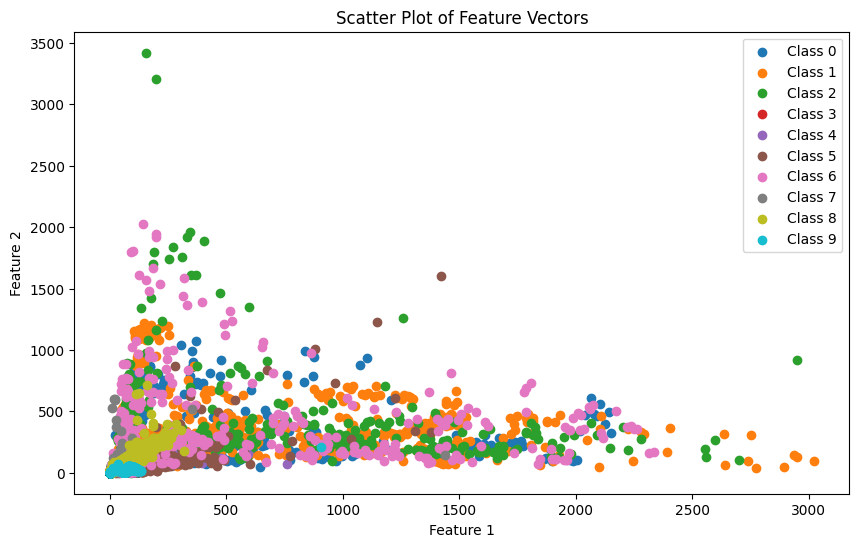

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

for class_label in range(10):
    # Select data points for the current class
    class_data = flat_data_arr[target_arr == class_label]

    # Scatter plot with a specific color for each class
    plt.scatter(class_data[:, 0], class_data[:, 1], label=f'Class {class_label}')

# Add labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Feature Vectors')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(flat_data_arr, target_arr, test_size=0.2, random_state=42)
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)

# # Apply PCA
# pca = PCA(n_components= 250)
# X_train_pca = pca.fit_transform(X_train)

In [ ]:
print(np.shape(X_train))
print(np.shape(y_train))

(28512, 768)
(28512,)


In [ ]:
svm_model = svm.SVC(kernel='rbf', C=1)
svm_model.fit(X_train, y_train)

SVC(C=1)

In [ ]:
predictions = svm_model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.59      0.67       653
           1       0.75      0.79      0.77       624
           2       0.60      0.73      0.66       867
           3       0.82      0.96      0.89       611
           4       0.88      0.84      0.86       751
           5       0.76      0.55      0.64       786
           6       0.75      0.66      0.70       663
           7       0.89      0.95      0.92       748
           8       1.00      1.00      1.00       607
           9       0.82      0.94      0.87       819

    accuracy                           0.80      7129
   macro avg       0.80      0.80      0.80      7129
weighted avg       0.80      0.80      0.79      7129



In [ ]:
svm_model2 = svm.SVC(kernel='rbf', C=10)
svm_model2.fit(X_train, y_train)
predictions2 = svm_model2.predict(X_test)
print(classification_report(y_test, predictions2))

              precision    recall  f1-score   support

           0       0.81      0.74      0.78       653
           1       0.85      0.87      0.86       624
           2       0.74      0.78      0.76       867
           3       0.90      0.98      0.94       611
           4       0.92      0.93      0.93       751
           5       0.88      0.73      0.80       786
           6       0.83      0.83      0.83       663
           7       0.96      0.97      0.96       748
           8       1.00      1.00      1.00       607
           9       0.89      0.97      0.93       819

    accuracy                           0.88      7129
   macro avg       0.88      0.88      0.88      7129
weighted avg       0.88      0.88      0.88      7129



In [ ]:
svm_model3 = svm.SVC(kernel='rbf', C=100)
svm_model3.fit(X_train, y_train)
predictions3 = svm_model3.predict(X_test)
print(classification_report(y_test, predictions3))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       630
           1       0.81      0.82      0.82       678
           2       0.86      0.85      0.86       689
           3       1.00      1.00      1.00       607
           4       0.89      0.89      0.89       631
           5       0.94      0.94      0.94       729
           6       0.93      0.97      0.95       751
           7       0.91      0.80      0.85       789
           8       0.81      0.83      0.82       844
           9       0.96      0.96      0.96       781

    accuracy                           0.90      7129
   macro avg       0.90      0.90      0.90      7129
weighted avg       0.90      0.90      0.90      7129



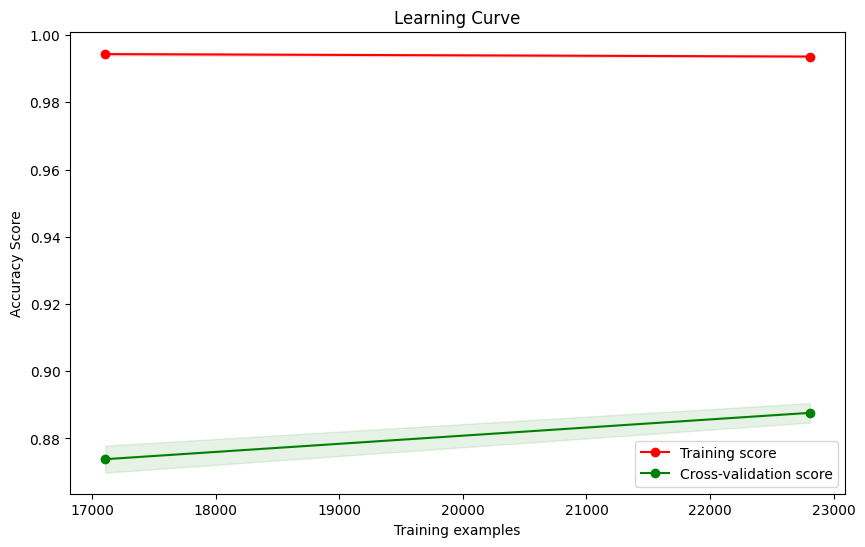

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(svm_model3, X_train, y_train, train_sizes=[0.75, 1.0], scoring='accuracy', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("Accuracy Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

In [ ]:
# defining parameter range
param_grid = {'C': [1, 10, 100 ],
              'gamma': [1, 10, 100 ],
              'kernel': ['rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, cv = 2, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2] END ..........C=1, gamma=1, kernel=rbf;, score=0.124 total time= 8.1min
[CV 2/2] END ..........C=1, gamma=1, kernel=rbf;, score=0.124 total time= 8.3min
[CV 1/2] END .........C=1, gamma=10, kernel=rbf;, score=0.124 total time= 8.3min
[CV 2/2] END .........C=1, gamma=10, kernel=rbf;, score=0.124 total time= 8.3min
[CV 1/2] END ........C=1, gamma=100, kernel=rbf;, score=0.124 total time= 8.2min
[CV 2/2] END ........C=1, gamma=100, kernel=rbf;, score=0.124 total time= 8.3min
[CV 1/2] END .........C=10, gamma=1, kernel=rbf;, score=0.124 total time= 8.5min
[CV 2/2] END .........C=10, gamma=1, kernel=rbf;, score=0.124 total time= 8.4min
[CV 1/2] END ........C=10, gamma=10, kernel=rbf;, score=0.124 total time= 8.3min
[CV 2/2] END ........C=10, gamma=10, kernel=rbf;, score=0.124 total time= 8.3min
[CV 1/2] END .......C=10, gamma=100, kernel=rbf;, score=0.124 total time= 8.2min
[CV 2/2] END .......C=10, gamma=100, kernel=rbf;,

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [1, 10, 100], 'gamma': [1, 10, 100],
                         'kernel': ['rbf']},
             verbose=3)

In [ ]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100 ],
              'gamma': [1, 0.1, 0.01 ],
              'kernel': ['rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_train, y_train)

In [ ]:
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

In [ ]:
grid_predictions = grid.predict(X_test)

# print classification report
print(classification_report(y_test, grid_predictions))

In [ ]:
#input size  (64,64) - accuracy 0.38 , precision 0.52, recall 0.39
#0.1 C 0.1 gama 0.122 score
#1 C 0.1 gamma 0.122 score